In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
df = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
df.head(3)

def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [3]:
df.head(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [4]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [5]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [6]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [7]:
print(len(cataract),len(normal))

594 500


In [8]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset




In [9]:
dataset = create_dataset(cataract,1)

len(dataset)

dataset = create_dataset(normal,0)

len(dataset)

100%|██████████| 500/500 [00:05<00:00, 95.96it/s] 


1088

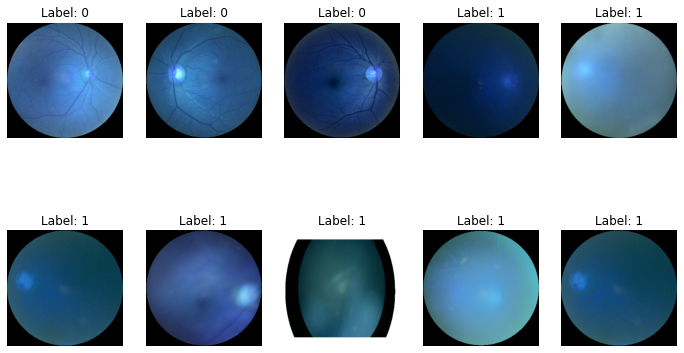

In [10]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    plt.subplot(2,5,i+1)
    image = dataset[sample][0]
    plt.imshow(image)
    plt.axis("off")
    label = dataset[sample][1]
    plt.title("Label: {}".format(label))
plt.show()

In [11]:
# First, we need to split the dataset into a training set and a validation set
from sklearn.model_selection import train_test_split

X = [datapoint[0] for datapoint in dataset] # Extract the images from the dataset
y = [datapoint[1] for datapoint in dataset] # Extract the labels from the dataset

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) # Split the data into 80% training and 20% validation

In [12]:
# Next, we will preprocess the images by normalizing the pixel values
X_train = np.array(X_train) / 255.0
X_val = np.array(X_val) / 255.0

In [13]:
# Now we will define the CNN model using the Keras API
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

model = Sequential()

In [14]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# Preprocess the data
image_size = 224
X = []  # list to hold the images
y = []  # list to hold the labels

# Iterate over the images and labels
for image, label in dataset:
    # Resize the image to the desired size
    image = cv2.resize(image, (image_size, image_size))
    
    # Add the image and label to the lists
    X.append(image)
    y.append(label)
    
# Convert the lists to numpy arrays
X = np.array(X)
y = np.array(y)


In [16]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Import necessary libraries
import tensorflow as tf

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(image_size, image_size, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_396 (Conv2D)          (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_397 (Conv2D)          (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_398 (Conv2D)          (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 86528)            

In [39]:
# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
28/28 [==============================] - 34s 1s/step - loss: 59.3180 - accuracy: 0.4943 - val_loss: 0.6736 - val_accuracy: 0.5550
Epoch 2/20
28/28 [==============================] - 32s 1s/step - loss: 0.6486 - accuracy: 0.5874 - val_loss: 0.6424 - val_accuracy: 0.6330
Epoch 3/20
28/28 [==============================] - 32s 1s/step - loss: 0.6301 - accuracy: 0.6299 - val_loss: 0.6392 - val_accuracy: 0.6330
Epoch 4/20
28/28 [==============================] - 32s 1s/step - loss: 0.6082 - accuracy: 0.6552 - val_loss: 0.6187 - val_accuracy: 0.6789
Epoch 5/20
28/28 [==============================] - 32s 1s/step - loss: 0.5898 - accuracy: 0.6793 - val_loss: 0.6032 - val_accuracy: 0.6881
Epoch 6/20
28/28 [==============================] - 32s 1s/step - loss: 0.5862 - accuracy: 0.6874 - val_loss: 0.7071 - val_accuracy: 0.5917
Epoch 7/20
28/28 [==============================] - 32s 1s/step - loss: 0.5787 - accuracy: 0.6816 - val_loss: 0.6292 - val_accuracy: 0.6881
Epoch 8/20
28/28 [=

In [40]:
# Fine-tune and optimize the model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

history = model.fit(X_train, y_train, batch_size=32, epochs=10,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_reducer])#we have to discuss

Epoch 1/10
28/28 [==============================] - 32s 1s/step - loss: 0.4034 - accuracy: 0.8161 - val_loss: 0.6294 - val_accuracy: 0.7156
Epoch 2/10
28/28 [==============================] - 32s 1s/step - loss: 0.3406 - accuracy: 0.8379 - val_loss: 0.6711 - val_accuracy: 0.7110
Epoch 3/10
28/28 [==============================] - 32s 1s/step - loss: 0.3493 - accuracy: 0.8460 - val_loss: 0.6025 - val_accuracy: 0.7064
Epoch 4/10
28/28 [==============================] - 32s 1s/step - loss: 0.3728 - accuracy: 0.8218 - val_loss: 0.5420 - val_accuracy: 0.7294
Epoch 5/10
28/28 [==============================] - 32s 1s/step - loss: 0.2803 - accuracy: 0.9080 - val_loss: 0.6412 - val_accuracy: 0.7706
Epoch 6/10
28/28 [==============================] - 32s 1s/step - loss: 0.2424 - accuracy: 0.9126 - val_loss: 0.6334 - val_accuracy: 0.7936
Epoch 7/10
28/28 [==============================] - 32s 1s/step - loss: 0.2122 - accuracy: 0.9322 - val_loss: 0.7105 - val_accuracy: 0.7798
Epoch 8/10
28/28 [==

In [41]:
loss,accuracy = model.evaluate(X_test,y_test)

7/7 [==============================] - 2s 246ms/step - loss: 0.6526 - accuracy: 0.7982


In [42]:
print("loss:",loss)
print("Accuracy:",accuracy)

loss: 0.6525994539260864
Accuracy: 0.7981651425361633


In [43]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [44]:
# Obtain the predicted probability values for the test data
y_pred = model.predict(X_test)

# Convert the predicted probability values to class labels
y_pred = (y_pred > 0.5).astype(int)

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.67      0.76       103
           1       0.76      0.91      0.83       115

    accuracy                           0.80       218
   macro avg       0.81      0.79      0.79       218
weighted avg       0.81      0.80      0.79       218



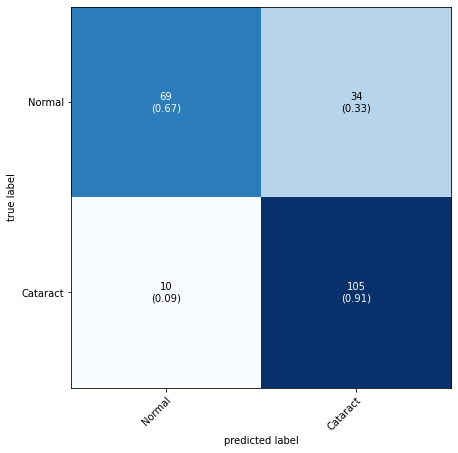

In [46]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
                      show_normed = True);

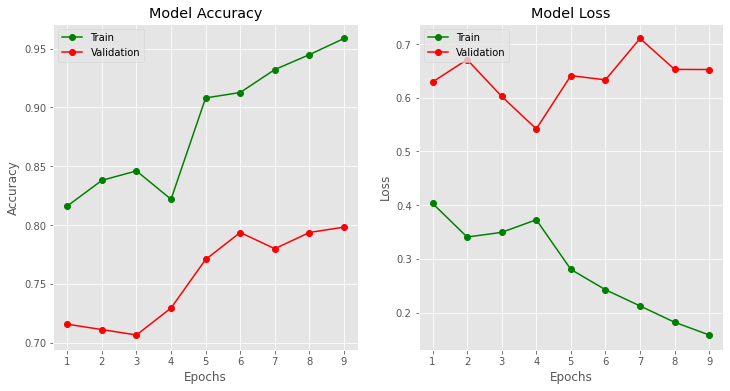

In [47]:
import matplotlib.pyplot as plt

# Use the "ggplot" style for the plots
plt.style.use("ggplot")

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Get the training and validation accuracy and loss
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Get the number of epochs
epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
ax[0].plot(epochs, acc, "go-", label="Train")
ax[0].plot(epochs, val_acc, "ro-", label="Validation")
ax[0].set_title("Model Accuracy")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc="upper left")

# Plot the training and validation loss
ax[1].plot(epochs, loss, "go-", label="Train")
ax[1].plot(epochs, val_loss, "ro-", label="Validation")
ax[1].set_title("Model Loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend(loc="upper left")

# Show the plots
plt.show()

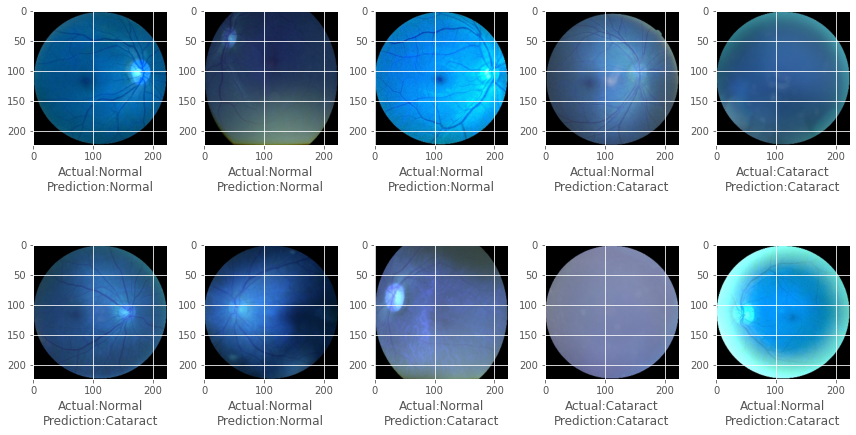

In [48]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(X_test)))
    image = X_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 


### 

In [49]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the base DenseNet model
image_size = 224  # Ensure this matches the size expected by DenseNet
base_model = DenseNet121(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

# Load the pre-trained weights into the base model
weights_path = '/kaggle/input/lkjhff/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model.load_weights(weights_path)

# Confirm that the base model layers are loaded correctly
# by inspecting the base_model.summary()

# Now, add your custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Example of an additional layer
predictions = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
# Example training command - adjust epochs and batch_size as needed
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
22/22 [==============================] - 182s 8s/step - loss: 0.3840 - accuracy: 0.8879 - val_loss: 50.7715 - val_accuracy: 0.5805
Epoch 2/10
22/22 [==============================] - 162s 7s/step - loss: 0.1579 - accuracy: 0.9483 - val_loss: 1.0277 - val_accuracy: 0.8908
Epoch 3/10
22/22 [==============================] - 162s 7s/step - loss: 0.1232 - accuracy: 0.9583 - val_loss: 2.3117 - val_accuracy: 0.5977
Epoch 4/10
22/22 [==============================] - 161s 7s/step - loss: 0.1533 - accuracy: 0.9497 - val_loss: 17.7224 - val_accuracy: 0.6034
Epoch 5/10
22/22 [==============================] - 162s 7s/step - loss: 0.1113 - accuracy: 0.9641 - val_loss: 25.4805 - val_accuracy: 0.6207
Epoch 6/10
22/22 [==============================] - 162s 7s/step - loss: 0.0941 - accuracy: 0.9727 - val_loss: 0.5616 - val_accuracy: 0.8966
Epoch 7/10
22/22 [==============================] - 162s 7s/step - loss: 0.1212 - accuracy: 0.9626 - val_loss: 0.1951 - val_accuracy: 0.9598
Epoch 8/10

In [51]:
loss,accuracy = model.evaluate(X_test,y_test)

7/7 [==============================] - 13s 2s/step - loss: 0.6204 - accuracy: 0.7982


In [52]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [53]:
# Obtain the predicted probability values for the test data
y_pred = model.predict(X_test)

# Convert the predicted probability values to class labels
y_pred = (y_pred > 0.5).astype(int)

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.89      0.81       103
           1       0.88      0.71      0.79       115

    accuracy                           0.80       218
   macro avg       0.81      0.80      0.80       218
weighted avg       0.81      0.80      0.80       218



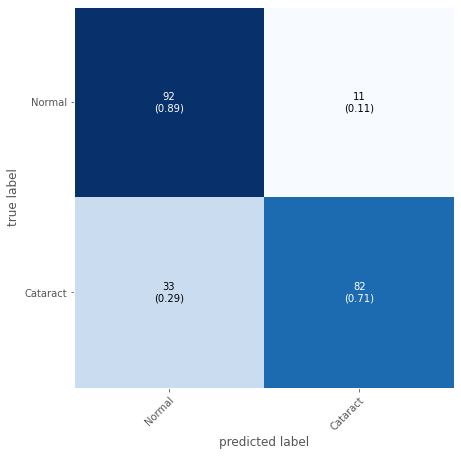

In [55]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
                      show_normed = True);

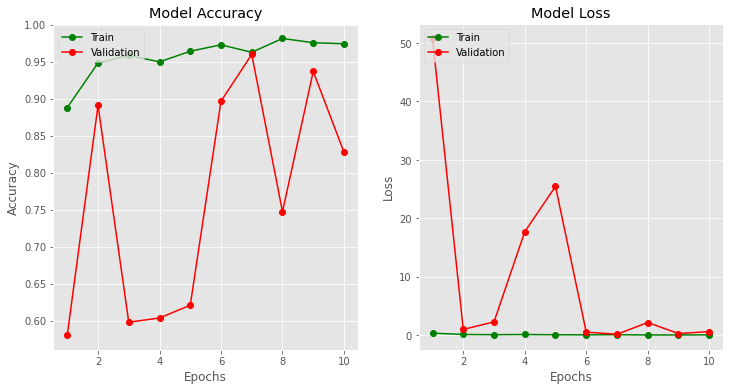

In [56]:
import matplotlib.pyplot as plt

# Use the "ggplot" style for the plots
plt.style.use("ggplot")

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Get the training and validation accuracy and loss
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Get the number of epochs
epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
ax[0].plot(epochs, acc, "go-", label="Train")
ax[0].plot(epochs, val_acc, "ro-", label="Validation")
ax[0].set_title("Model Accuracy")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc="upper left")

# Plot the training and validation loss
ax[1].plot(epochs, loss, "go-", label="Train")
ax[1].plot(epochs, val_loss, "ro-", label="Validation")
ax[1].set_title("Model Loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend(loc="upper left")

# Show the plots
plt.show()

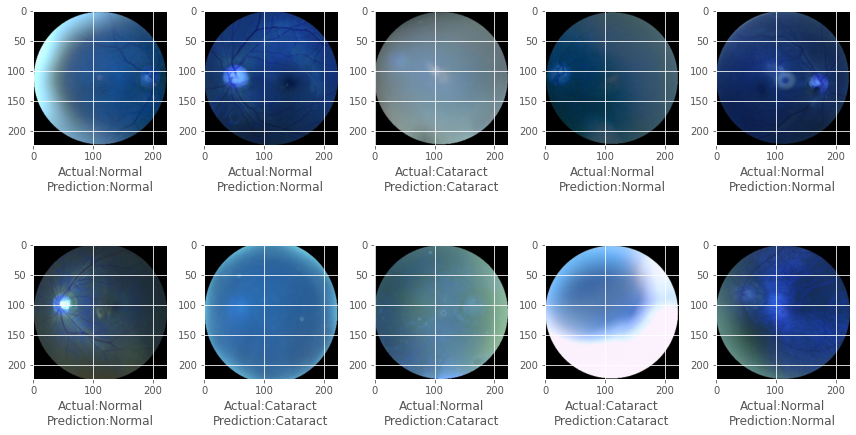

In [57]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(X_test)))
    image = X_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 

### Inception

In [58]:
# from tensorflow.keras.applications import InceptionV3
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

# # Define the base InceptionV3 model
# image_size = 299  # InceptionV3 requires input images to be at least 75x75
# base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# # Now, add your custom layers on top of the base model
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)  # Example of an additional layer
# predictions = Dense(1, activation='sigmoid')(x)

# # Final model
# model = Model(inputs=base_model.input, outputs=predictions)

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# # Example training command - adjust epochs and batch_size as needed
# history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)


from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224, 224, 3)

# Define the base InceptionV3 model
base_model = InceptionV3(weights=None, include_top=False, input_shape=input_shape)

# Load the pre-trained weights into the base model
weights_path = '/kaggle/input/12nkkjnk/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model.load_weights(weights_path)

# Now, add your custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Example of an additional layer
predictions = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
# model.summary()

In [59]:
# Example training command - adjust epochs, batch_size, and validation_split as needed
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
22/22 [==============================] - 145s 6s/step - loss: 0.4983 - accuracy: 0.8592 - val_loss: 370.7008 - val_accuracy: 0.5805
Epoch 2/10
22/22 [==============================] - 134s 6s/step - loss: 0.1765 - accuracy: 0.9454 - val_loss: 0.6053 - val_accuracy: 0.7299
Epoch 3/10
22/22 [==============================] - 134s 6s/step - loss: 0.1444 - accuracy: 0.9440 - val_loss: 2.2260 - val_accuracy: 0.6264
Epoch 4/10
22/22 [==============================] - 134s 6s/step - loss: 0.1314 - accuracy: 0.9526 - val_loss: 0.3658 - val_accuracy: 0.8851
Epoch 5/10
22/22 [==============================] - 134s 6s/step - loss: 0.0829 - accuracy: 0.9655 - val_loss: 0.4102 - val_accuracy: 0.9138
Epoch 6/10
22/22 [==============================] - 135s 6s/step - loss: 0.0843 - accuracy: 0.9655 - val_loss: 0.4559 - val_accuracy: 0.9023
Epoch 7/10
22/22 [==============================] - 133s 6s/step - loss: 0.0648 - accuracy: 0.9727 - val_loss: 0.3583 - val_accuracy: 0.9195
Epoch 8/10


In [60]:
loss,accuracy = model.evaluate(X_test,y_test)

7/7 [==============================] - 11s 2s/step - loss: 0.4419 - accuracy: 0.9083


In [61]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
# Obtain the predicted probability values for the test data
y_pred = model.predict(X_test)

# Convert the predicted probability values to class labels
y_pred = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       103
           1       1.00      0.83      0.90       115

    accuracy                           0.91       218
   macro avg       0.92      0.91      0.91       218
weighted avg       0.92      0.91      0.91       218



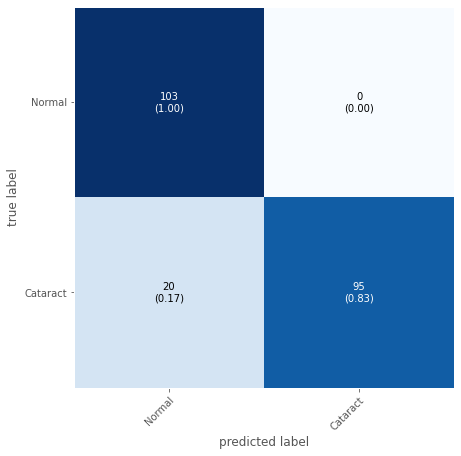

In [62]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
                      show_normed = True);

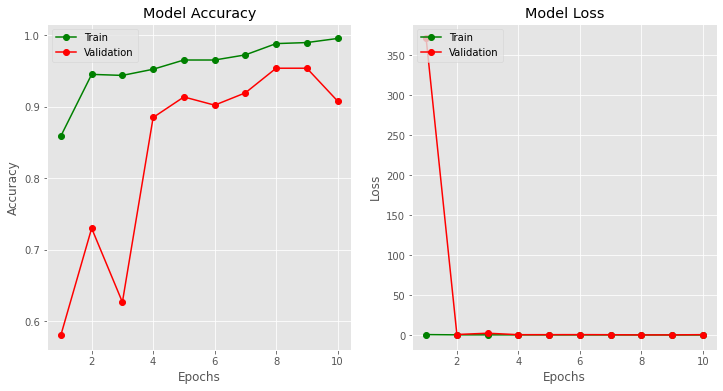

In [63]:
import matplotlib.pyplot as plt

# Use the "ggplot" style for the plots
plt.style.use("ggplot")

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Get the training and validation accuracy and loss
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Get the number of epochs
epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
ax[0].plot(epochs, acc, "go-", label="Train")
ax[0].plot(epochs, val_acc, "ro-", label="Validation")
ax[0].set_title("Model Accuracy")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc="upper left")

# Plot the training and validation loss
ax[1].plot(epochs, loss, "go-", label="Train")
ax[1].plot(epochs, val_loss, "ro-", label="Validation")
ax[1].set_title("Model Loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend(loc="upper left")

# Show the plots
plt.show()

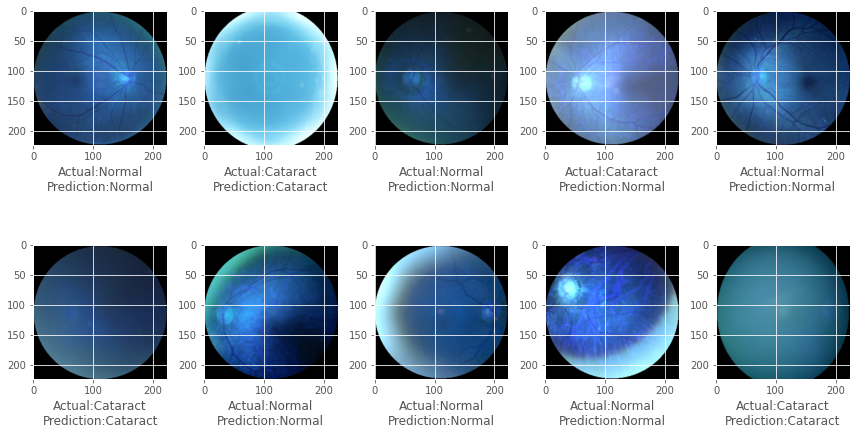

In [64]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(X_test)))
    image = X_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 